In [3]:
import os
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

DIR = "./data-with-sentiment"

SUM_FILE_NAME = 'summary.json'
CAT_FILE_NAME = DIR+'/subsets.txt'

cats = {}
with open(CAT_FILE_NAME) as file:
    for line in file:
        temp = line.split(': ')
        cats[temp[0]] = [id.strip('\'') for id in temp[1].strip('[').strip(']\n').split(', ')]
print(cats)

def summarize_data():
    posts = {'reddit':{}, 'youtube':{}}
    csv_data =[]
    # reddit_categories = ['Music', 'gaming', 'politics', 'LifeProTips']
    # youtube_categories = ['music', 'gaming', 'news', 'howto']
    csv_row = []
    last_post_hash= ''
    for _, _, files in os.walk(DIR, topdown=False):
        files.sort()
        for name in files:
            # open file
            if not name.endswith('json'):
                continue
            f = open(DIR+'/'+name,)
            data = json.load(f)
            post_num = int(name.split('-appended')[0].split('_')[-1])
            if 'views' not in data: # reddit data
                post_hash = data['post_url']
                if post_hash not in posts['reddit']:
                    post = {}
                    post['ups']=[0]*41
                    post['downs']=[0]*41
                    post['ups/downs']=[0]*41
                    post['pTop']=[0]*41
                    post['sTop']=[0]*41
                    post['pBest']=[0]*41
                    post['sBest']=[0]*41
                    post['pHot']=[0]*41
                    post['sHot']=[0]*41
                    for k, v in cats.items():
                        if post_hash in v:
                            post['cat'] = k
                    posts['reddit'][post_hash]=post
                p=0
                s=0
                if 'top_comments_top' in data:
                    for top_com in data['top_comments_top']:
                        p+=float(top_com['polarity'])
                        s+=float(top_com['subjectivity'])
                    if len(data['top_comments_top'])!=0:
                        p/=len(data['top_comments_top'])
                        s/=len(data['top_comments_top'])
                posts['reddit'][post_hash]['pTop'][post_num]=p
                posts['reddit'][post_hash]['sTop'][post_num]=s

                p=0
                s=0
                if 'top_comments_best' in data:
                    for top_com in data['top_comments_best']:
                        p+=float(top_com['polarity'])
                        s+=float(top_com['subjectivity'])
                    if len(data['top_comments_best'])!=0:
                        p/=len(data['top_comments_best'])
                        s/=len(data['top_comments_best'])
                posts['reddit'][post_hash]['pBest'][post_num]=p
                posts['reddit'][post_hash]['sBest'][post_num]=s

                p=0
                s=0
                if 'top_comments_hot' in data:
                    for top_com in data['top_comments_hot']:
                        p+=float(top_com['polarity'])
                        s+=float(top_com['subjectivity'])
                    if len(data['top_comments_hot'])!=0:
                        p/=len(data['top_comments_hot'])
                        s/=len(data['top_comments_hot'])
                posts['reddit'][post_hash]['pHot'][post_num]=p
                posts['reddit'][post_hash]['sHot'][post_num]=s
                posts['reddit'][post_hash]['ups'][post_num]=int(data['ups'])
                posts['reddit'][post_hash]['downs'][post_num]=int(data['downs'])
                if int(data['downs'])!=0:
                    posts['reddit'][post_hash]['ups/downs'][post_num]=int(data['ups'])/int(data['downs'])
            else: # youtube data
                post_hash = data['url'].split('v=')[1]
                if post_hash not in posts['youtube']:
                    if len(csv_row)!=0:
                        csv_row.extend(posts['youtube'][last_post_hash]['ups'])
                        csv_row.extend(posts['youtube'][last_post_hash]['downs'])
                        csv_row.extend(posts['youtube'][last_post_hash]['views'])
                        csv_row.extend(posts['youtube'][last_post_hash]['ups/downs'])
                        csv_row.extend(posts['youtube'][last_post_hash]['pTop'])
                        csv_row.extend(posts['youtube'][last_post_hash]['sTop'])
                        csv_row.extend(posts['youtube'][last_post_hash]['p'])
                        csv_row.extend(posts['youtube'][last_post_hash]['s'])
                        csv_data.append(csv_row)
                    csv_row = []
                    csv_row.append(post_hash)
                    post = {}
                    post['ups']=[0]*41
                    post['downs']=[0]*41
                    post['views']=[0]*41
                    post['ups/downs']=[0]*41
                    post['pTop']=[0]*41 #p of top comments till that sample
                    post['sTop']=[0]*41 #s of top comments till that sample
                    post['p']=[0]*41 # polarity of new comments since last sample
                    post['s']=[0]*41 # s of new comments since last sample
                    for k, v in cats.items():
                        if post_hash in v:
                            post['cat'] = k
                            csv_row.append(k)
                    posts['youtube'][post_hash]=post
                posts['youtube'][post_hash]['ups'][post_num]=int(data['ups'])
                posts['youtube'][post_hash]['downs'][post_num]=int(data['downs'])
                posts['youtube'][post_hash]['views'][post_num]=int(data['views'])
                p=0
                s=0
                if 'top_comments' in data:
                    for top_com in data['top_comments']:
                        p+=float(top_com['polarity'])
                        s+=float(top_com['subjectivity'])
                    if len(data['top_comments'])!=0:
                        p/=len(data['top_comments'])
                        s/=len(data['top_comments'])
                    posts['youtube'][post_hash]['pTop'][post_num]=p
                    posts['youtube'][post_hash]['sTop'][post_num]=s
                p=0
                s=0
                if 'comments_since_last_sample' in data:
                    for top_com in data['comments_since_last_sample']:
                        p+=float(top_com['polarity'])
                        s+=float(top_com['subjectivity'])
                    if len(data['comments_since_last_sample'])!=0:
                        p/=len(data['comments_since_last_sample'])
                        s/=len(data['comments_since_last_sample'])
                    posts['youtube'][post_hash]['p'][post_num]=p
                    posts['youtube'][post_hash]['s'][post_num]=s
                if int(data['downs'])!=0:
                    posts['youtube'][post_hash]['ups/downs'][post_num]=int(data['ups'])/int(data['downs'])
                last_post_hash= post_hash
    csv_data.append(csv_row)
    return posts, csv_data

def save_summary(posts):
    with open(SUM_FILE_NAME, 'w') as f:
        json.dump(posts, f)

def load_summary():
    with open(SUM_FILE_NAME, 'r') as f:
        posts = json.load(f)
        return posts

def save_csv(data):
    with open("out.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(data)

def get_summary():
    if os.path.isfile(SUM_FILE_NAME):
        posts = load_summary()
    else:
        posts, csv_data = summarize_data()
        save_summary(posts)
        save_csv(csv_data)
    return posts

{'Reddit - Music': ['https://www.reddit.com/r/Music/comments/qj5c5l/youtube_channel/', 'https://www.reddit.com/r/Music/comments/qj5brj/alisky_on_music_creator/', 'https://www.reddit.com/r/Music/comments/qj53r4/the_hanging_bandits_werewolves_of_paternoster/', 'https://www.reddit.com/r/Music/comments/qj4reu/insides_rollin_trapmetal/', 'https://www.reddit.com/r/Music/comments/qj4pr8/ellis_b_album_one_dance_i_just_released_my_first/', 'https://www.reddit.com/r/Music/comments/qj4g8m/end_of_the_world/', 'https://www.reddit.com/r/Music/comments/qj4dzm/the_lair_of_the_white_worm_the_dampton_worm_song/', 'https://www.reddit.com/r/Music/comments/qj4dmx/dexter_season_1_episode_1/', 'https://www.reddit.com/r/Music/comments/qj4bvs/jack_morley_close_guitar_beat/', 'https://www.reddit.com/r/Music/comments/qj4asa/zanthiago_lópez_embrujo_reggaetón/', 'https://www.reddit.com/r/Music/comments/qj445l/rappers_singers/', 'https://www.reddit.com/r/Music/comments/qj40hc/prtty_ridiculous_rheumy_official_music_

In [4]:
topics = []
with open('topic_postsYouTube - gaming.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # displaying the contents of the CSV file
  for lines in csvFile:
        topics.append(lines)

In [5]:
posts = get_summary()

In [6]:
df = pd.DataFrame(posts['youtube'])
# %%
df = df.transpose()
# %%
d1 = df.loc[df['cat'] == 'YouTube - gaming']

In [7]:
d2  = d1['ups'].apply(pd.Series)

In [20]:
d2['sigma4'] = d2[40]-d2[31]

In [21]:
d2.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,sigma,sigma1,sigma2,sigma3,sigma4
-lUtPDYnKL0,6092,8117,9128,9701,10285,10811,11179,11413,11567,11706,...,13587,13610,13635,13665,13697,7605,5782,870,494,243
2E8KgPJ5XlE,1116,1387,1491,1553,1621,1662,1709,1735,1763,1777,...,2034,2042,2048,2057,2063,947,687,111,54,64
46lG1EhQvMc,7205,15386,17398,19281,21016,26364,35740,38882,40704,42317,...,72486,73099,73549,73802,74154,66949,36697,14350,7543,4097
6C2NSRtvkm8,3474,6551,8242,9241,10114,10973,11711,12278,12851,13243,...,18273,18340,18401,18471,18536,15062,10044,2479,1270,679
6MHMGOXgkgY,5526,7819,8964,10052,10936,11635,12032,12273,12419,12559,...,14285,14308,14324,14336,14352,8826,7197,938,296,184


In [14]:
d4 = d1['p'].apply(pd.Series)

In [15]:
d4['sigma_s'] = d4[40]-d4[0]

In [16]:
trendy = d2.loc[d2['sigma']>= d2.sigma.mean()].index.to_list()
not_trendy = d2.loc[d2['sigma']<d2.sigma.mean()].index.to_list()

In [22]:
# for h2: potentially trendy videos
ptrendy = d2.loc[d2['sigma1']>= d2.sigma1.mean()].index.to_list()
not_ptrendy = d2.loc[d2['sigma1']<d2.sigma1.mean()].index.to_list()

In [113]:
d1_trendy = d1.loc[d1.index.isin(trendy)]
d1_not_trendy = d1.loc[d1.index.isin(not_trendy)]

In [23]:
d1_ptrendy = d1.loc[d1.index.isin(trendy)]
d1_not_ptrendy = d1.loc[d1.index.isin(not_trendy)]

In [27]:
d4_trendy = d4.loc[d4.index.isin(trendy)]
d4_not_trendy = d4.loc[d4.index.isin(not_trendy)]

In [29]:
d4_not_trendy['sigma_s'].mean()

-0.017963127144942845

In [47]:
d3 =d1.explode('p')[['index', 'p']]

In [307]:
dfp_t = d1_trendy['pTop'].apply(pd.Series)
dfp_nt = d1_not_trendy['pTop'].apply(pd.Series)

In [25]:
dfp_th2 = d1_ptrendy['ups'].apply(pd.Series)
dfp_nth2 = d1_not_ptrendy['ups'].apply(pd.Series)

In [32]:
dfp_th2.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
46lG1EhQvMc,7205,15386,17398,19281,21016,26364,35740,38882,40704,42317,...,70057,70520,70811,71185,71867,72486,73099,73549,73802,74154
6dOqeFBvvZs,4590,15094,20373,23476,26297,28815,30945,32227,32965,33590,...,40892,40965,41009,41072,41163,41235,41319,41382,41424,41479
75DEffOWhT8,4031,12060,14421,15613,16976,18323,20743,21680,22309,22964,...,29024,29160,29219,29274,29339,29410,29499,29578,29641,29683
KE8zYIoR0nI,59221,92819,107326,119543,133253,146196,156902,163456,167422,171894,...,225796,226609,227295,227949,229546,230832,231929,232740,233399,234133
MSPdvM4eQ5A,2928,4620,6971,9065,11201,13526,16018,17736,18812,19780,...,39586,40798,41732,42761,44182,45498,46750,47641,48364,49394


In [308]:
dfp_t['trendy']='true'
dfp_nt['trendy']='false'

In [27]:
dfph2 = pd.concat([dfp_th2, dfp_nth2], axis=0)
dfph2['topic']=0

In [29]:
df['mean']=dfp.loc[:,0:40].mean(axis=1)
dfph2.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,topic
46lG1EhQvMc,7205,15386,17398,19281,21016,26364,35740,38882,40704,42317,...,70520,70811,71185,71867,72486,73099,73549,73802,74154,0
6dOqeFBvvZs,4590,15094,20373,23476,26297,28815,30945,32227,32965,33590,...,40965,41009,41072,41163,41235,41319,41382,41424,41479,0
75DEffOWhT8,4031,12060,14421,15613,16976,18323,20743,21680,22309,22964,...,29160,29219,29274,29339,29410,29499,29578,29641,29683,0
KE8zYIoR0nI,59221,92819,107326,119543,133253,146196,156902,163456,167422,171894,...,226609,227295,227949,229546,230832,231929,232740,233399,234133,0
MSPdvM4eQ5A,2928,4620,6971,9065,11201,13526,16018,17736,18812,19780,...,40798,41732,42761,44182,45498,46750,47641,48364,49394,0


In [311]:
ind=0
for topic in topics:
    for post in topic:
        dfp.loc[dfp.index == post, 'topic']=ind
    ind+=1

In [312]:
dfp_t=dfp.loc[dfp.trendy=='true']
dfp_nt=dfp.loc[dfp.trendy=='false']

In [313]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import f_oneway

mod = ols('mean ~ topic', data=dfp_t[['mean', 'topic']]).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for trendy videos')
print('----------------------')
print(aov_table)
print()

mod = ols('mean ~ topic', data=dfp_nt[['mean', 'topic']]).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for not trendy videos')
print('----------------------')
print(aov_table)
print()

mod = ols('mean ~ topic', data=dfp[['mean', 'topic']]).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for all videos')
print('----------------------')
print(aov_table)
print()


# #perform two-way ANOVA
# model = ols('mean ~ C(trendy) + C(topic) + C(trendy):C(topic)', data=dfp[['mean', 'topic', 'trendy']]).fit()
# sm.stats.anova_lm(model, typ=2)

ANOVA table for trendy videos
----------------------
            sum_sq    df         F    PR(>F)
topic     0.004925   1.0  0.927377  0.358254
Residual  0.053102  10.0       NaN       NaN

ANOVA table for not trendy videos
----------------------
            sum_sq    df         F   PR(>F)
topic     0.053628   1.0  2.905593  0.09689
Residual  0.664441  36.0       NaN      NaN

ANOVA table for all videos
----------------------
            sum_sq    df         F    PR(>F)
topic     0.028806   1.0  1.830398  0.182419
Residual  0.755393  48.0       NaN       NaN



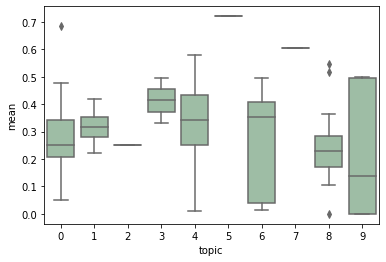

In [292]:
import seaborn as sns
ax = sns.boxplot(x='topic', y='mean', data=dfp[['topic', 'mean']], color='#99c2a2')
# ax = sns.swarmplot(x='variable', y='value', data=dfp1, color='#7d0013')

In [ ]:
x = np.array([1, 2, 3, 4])  # X-axis points
y = x*2  # Y-axis points
  
plt.plot(x, y)  # Plot the chart
plt.show() 

In [172]:
for i in range(0,4):
    dfp_t['mean'+str(i)]=dfp_t.loc[:,i*10:i*10+9].mean(axis=1)
    dfp_nt['mean'+str(i)]=dfp_nt.loc[:,i*10:i*10+9].mean(axis=1)
#     print(dfp.loc[:,i*10:i*10+9].mean(axis=1))

In [173]:
dfp_t1 = pd.melt(dfp_t.reset_index(), id_vars=['index'], value_vars=['mean0', 'mean1', 'mean2', 'mean3'])
dfp_nt1 = pd.melt(dfp_nt.reset_index(), id_vars=['index'], value_vars=['mean0', 'mean1', 'mean2', 'mean3'])

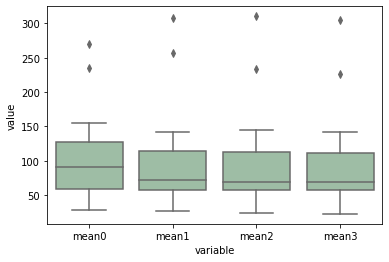

In [174]:
import seaborn as sns
ax = sns.boxplot(x='variable', y='value', data=dfp_t1, color='#99c2a2')
# ax = sns.swarmplot(x='variable', y='value', data=dfp1, color='#7d0013')


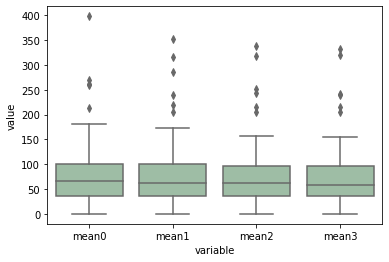

In [175]:
plt.clf()
ax1 = sns.boxplot(x='variable', y='value', data=dfp_nt1, color='#99c2a2')

In [176]:
from statsmodels.stats.anova import AnovaRM
print(AnovaRM(data=dfp_t1, depvar='value', subject='index', within=['variable']).fit())

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
variable  1.1905 3.0000 33.0000 0.3284



In [177]:
print(AnovaRM(data=dfp_nt1, depvar='value', subject='index', within=['variable']).fit())

                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
variable  0.7763 3.0000 111.0000 0.5096

